# Reusable Embeddings

**Learning Objectives**
1. Learn how to use a pre-trained TF Hub text modules to generate sentence vectors
1. Learn how to incorporate a pre-trained TF-Hub module into a Keras model
1. Learn how to deploy and use a text model on CAIP


## Introduction


In this notebook, we will implement text models to recognize the probable source (Github, Tech-Crunch, or The New-York Times) of the titles we have in the title dataset.

First, we will load and pre-process the texts and labels so that they are suitable to be fed to sequential Keras models with first layer being TF-hub pre-trained modules. Thanks to this first layer, we won't need to tokenize and integerize the text before passing it to our models. The pre-trained layer will take care of that for us, and consume directly raw text. However, we will still have to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will build, train and compare simple DNN models starting with different pre-trained TF-Hub layers.

In [1]:
import os

from google.cloud import bigquery
import pandas as pd

Replace the variable values in the cell below:

In [3]:
PROJECT = "qwiklabs-gcp-00-eeb852ce8ccb"  # Replace with your PROJECT
BUCKET = PROJECT  # defaults to PROJECT
REGION = "us-central1"  # Replace with your REGION

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

In [4]:
%%bash
gcloud config set project $PROJECT
gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

Here is a sample of the dataset:

In [5]:
%%bigquery --project $PROJECT

SELECT
    url, title, score
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    LENGTH(title) > 10
    AND score > 10
    AND LENGTH(url) > 0
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.31rows/s]


,url,title,score
0,http://www.dumpert.nl/mediabase/6560049/3eb18e...,"Calling the NSA: ""I accidentally deleted an e-...",258
1,http://blog.liip.ch/archive/2013/10/28/hhvm-an...,Amazing performance with HHVM and PHP with a S...,11
2,http://www.gamedev.net/page/resources/_/techni...,A Journey Through the CPU Pipeline,11
3,http://jfarcand.wordpress.com/2011/02/25/atmos...,"Atmosphere Framework 0.7 released: GWT, Wicket...",11
4,http://tech.gilt.com/post/90578399884/immutabl...,Immutable Infrastructure with Docker and EC2 [...,11
5,http://thechangelog.com/post/501053444/episode...,Changelog 0.2.0 - node.js w/Felix Geisendorfer,11
6,http://openangelforum.com/2010/09/09/second-bo...,Second Open Angel Forum in Boston Oct 13th--fr...,11
7,http://bredele.github.io/async,A collection of JavaScript asynchronous patterns,11
8,http://www.smashingmagazine.com/2007/08/25/20-...,20 Free and Fresh Icon Sets,11
9,http://www.cio.com/article/147801/Study_Finds_...,"Study: Only 1 in 5 Workers is ""Engaged"" in The...",11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

In [6]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source,
    COUNT(title) AS num_articles
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
GROUP BY
    source
ORDER BY num_articles DESC
  LIMIT 100

Downloading: 100%|██████████| 100/100 [00:01<00:00, 88.85rows/s] 


,source,num_articles
0,blogspot,41386
1,github,36525
2,techcrunch,30891
3,youtube,30848
4,nytimes,28787
...,...,...
95,f5,1254
96,gamasutra,1249
97,cnbc,1229
98,indiatimes,1223


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [7]:
regex = '.*://(.[^/]+)/'


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(regex)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(sub_query=sub_query)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [8]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,feminist-software-foundation complains about r...,github
1,expose sps as web services on the fly.,github
2,show hn scrwl shorthand code reading and wr...,github
3,geoip module on nodejs now is a c addon,github
4,show hn linuxexplorer,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [9]:
print("The full dataset contains {n} titles".format(n=len(title_dataset)))

The full dataset contains 96203 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [10]:
title_dataset.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [11]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [12]:
FULL_DATASET_NAME = 'titles_full.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

In [13]:
sample_title_dataset = title_dataset.sample(n=1000)
sample_title_dataset.source.value_counts()

github        399
techcrunch    315
nytimes       286
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [14]:
SAMPLE_DATASET_NAME = 'titles_sample.csv'
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding='utf-8')

In [15]:
sample_title_dataset.head()

,title,source
93131,scribd stats google analytics for documents,techcrunch
83916,dell q2 revenue down 8 with further drops exp...,techcrunch
88868,fake apple keynote leaked on wikipedia,techcrunch
11774,show hn using html hex-color-codes while codi...,github
74972,egnyte different perspective than box about c...,techcrunch


In [16]:
import datetime
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.6.0


In [17]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [18]:
MODEL_DIR = f"gs://{BUCKET}/text_models"

## Loading the dataset

As in the previous labs, our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times):

In [19]:
ls $DATADIR

titles_full.csv  titles_sample.csv


In [20]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATADIR, DATASET_NAME)
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,o3o - ascii emoticon generator based on node.j...,github
1,maluuba launches natural language processing api,techcrunch
2,how our taxi article happened to undercut the ...,nytimes
3,the difference between a true startup founder ...,techcrunch
4,backbonejs todo list example with spring 3.1 ...,github


Let's look again at the number of examples per label to make sure we have a well-balanced dataset:

In [21]:
titles_df.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

## Preparing the labels

In this lab, we will use pre-trained [TF-Hub embeddings modules for english](https://tfhub.dev/s?q=tf2%20embeddings%20text%20english) for the first layer of our models. One immediate
advantage of doing so is that the TF-Hub embedding module will take care for us of processing the raw text. 
This also means that our model will be able to consume text directly instead of sequences of integers representing the words.

However, as before, we still need to preprocess the labels into one-hot-encoded vectors:

In [22]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [23]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [24]:
encode_labels(titles_df.source[:4])

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [25]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per class.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.

In [26]:
sources_train.value_counts()

github        34714
techcrunch    29351
nytimes       27327
Name: source, dtype: int64

In [27]:
sources_valid.value_counts()

github        1811
techcrunch    1540
nytimes       1460
Name: source, dtype: int64

Now let's create the features and labels we will feed our models with:

In [28]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [29]:
X_train[:3]

array(['o3o - ascii emoticon generator based on node.js    ',
       'maluuba launches natural language processing api',
       'how our taxi article happened to undercut the efficient market hypothesis'],
      dtype=object)

In [30]:
Y_train[:3]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

## NNLM Model

We will first try a word embedding pre-trained using a [Neural Probabilistic Language Model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). TF-Hub has a 50-dimensional one called 
[nnlm-en-dim50-with-normalization](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1), which also
normalizes the vectors produced. 

Once loaded from its url, the TF-hub module can be used as a normal Keras layer in a sequential or functional model. Since we have enough data to fine-tune the parameters of the pre-trained embedding itself, we will set `trainable=True` in the `KerasLayer` that loads the pre-trained embedding:

In [31]:
# TODO 1
NNLM = "https://tfhub.dev/google/nnlm-en-dim50/2"

nnlm_module = KerasLayer(
    NNLM, output_shape=[50], input_shape=[], dtype=tf.string, trainable=True)

2021-10-25 20:30:35.329876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-10-25 20:30:35.329926: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-25 20:30:35.329950: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (asl): /proc/driver/nvidia/version does not exist
2021-10-25 20:30:35.330213: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-25 20:30:35.388

Note that this TF-Hub embedding produces a single 50-dimensional vector when passed a sentence:

In [32]:
# TODO 1
nnlm_module(tf.constant(["The dog is happy to see people in the street."]))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.19331802,  0.05893906,  0.15330684,  0.2505918 ,  0.19369544,
         0.03578748,  0.07387847, -0.10962156, -0.11377034,  0.07172022,
         0.12458669, -0.02289705, -0.18177685, -0.07084437, -0.00225849,
        -0.36875236,  0.05772953, -0.14222091,  0.08765972, -0.14068899,
        -0.07005888, -0.20634466,  0.07220475,  0.04258814,  0.0955702 ,
         0.19424029, -0.42492998, -0.00706906, -0.02095   , -0.05055764,
        -0.18988201, -0.02841404,  0.13222624, -0.01459922, -0.31255388,
        -0.09577855,  0.05469003, -0.13858607,  0.01141668, -0.12352604,
        -0.07250367, -0.11605677, -0.06976165,  0.14313601, -0.15183711,
        -0.06836402,  0.03054246, -0.13259597, -0.14599673,  0.05094011]],
      dtype=float32)>

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [33]:
# TODO 1
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

Similarly as the previous pre-trained embedding, it outputs a single vector when passed a sentence:

In [ ]:
# TODO 1
swivel_module(tf.constant(["The dog is happy to see people in the street."]))

## Building the models

Let's write a function that 

* takes as input an instance of a `KerasLayer` (i.e. the `swivel_module` or the `nnlm_module` we constructed above) as well as the name of the model (say `swivel` or `nnlm`)
* returns a compiled Keras sequential model starting with this pre-trained TF-hub layer, adding one or more dense relu layers to it, and ending with a softmax layer giving the probability of each of the classes:

In [34]:
def build_model(hub_module, name):
    model = Sequential([
        hub_module, # TODO 2
        Dense(16, activation='relu'),
        Dense(N_CLASSES, activation='softmax')
    ], name=name)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's also wrap the training code into a `train_and_evaluate` function that 
* takes as input the training and validation data, as well as the compiled model itself, and the `batch_size`
* trains the compiled model for 100 epochs at most, and does early-stopping when the validation loss is no longer decreasing
* returns an `history` object, which will help us to plot the learning curves

In [35]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping(patience=1), TensorBoard(model_dir)],
    )
    return history

## Training NNLM

In [36]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

In [37]:
nnlm_model = build_model(nnlm_module, 'nnlm')
nnlm_history = train_and_evaluate(data, val_data, nnlm_model)

2021-10-25 20:30:42.657486: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-25 20:30:42.657538: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-25 20:30:42.657971: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100


2021-10-25 20:30:45.683751: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 192762400 exceeds 10% of free system memory.
2021-10-25 20:30:45.748994: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 192762400 exceeds 10% of free system memory.
2021-10-25 20:30:46.129490: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 192762400 exceeds 10% of free system memory.
2021-10-25 20:30:46.130249: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 192762400 exceeds 10% of free system memory.


 1/19 [>.............................] - ETA: 20s - loss: 1.1013 - accuracy: 0.3740

2021-10-25 20:30:47.034149: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-25 20:30:47.034214: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/19 [==>...........................] - ETA: 20s - loss: 1.0951 - accuracy: 0.3850

2021-10-25 20:30:48.212482: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-25 20:30:48.213915: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-25 20:30:50.579595: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/nnlm/train/plugins/profile/2021_10_25_20_30_48

2021-10-25 20:30:50.932899: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/nnlm/train/plugins/profile/2021_10_25_20_30_48/asl.trace.json.gz
2021-10-25 20:30:51.130688: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/nnlm/train/plugins/profile/2021_10_25_20_30_48

2021-10-25 20:30:51.468326: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_pr

19/19 [==============================] - 22s 1s/step - loss: 1.0353 - accuracy: 0.4995 - val_loss: 0.9628 - val_accuracy: 0.6227
Epoch 2/100
19/19 [==============================] - 14s 756ms/step - loss: 0.8912 - accuracy: 0.6795 - val_loss: 0.8161 - val_accuracy: 0.7290
Epoch 3/100
19/19 [==============================] - 14s 762ms/step - loss: 0.7323 - accuracy: 0.7604 - val_loss: 0.6645 - val_accuracy: 0.7701
Epoch 4/100
19/19 [==============================] - 15s 764ms/step - loss: 0.5860 - accuracy: 0.8049 - val_loss: 0.5496 - val_accuracy: 0.8007
Epoch 5/100
19/19 [==============================] - 15s 771ms/step - loss: 0.4796 - accuracy: 0.8317 - val_loss: 0.4783 - val_accuracy: 0.8212
Epoch 6/100
19/19 [==============================] - 15s 769ms/step - loss: 0.4090 - accuracy: 0.8518 - val_loss: 0.4379 - val_accuracy: 0.8314
Epoch 7/100
19/19 [==============================] - 15s 772ms/step - loss: 0.3610 - accuracy: 0.8677 - val_loss: 0.4147 - val_accuracy: 0.8362
Epoch 8

<AxesSubplot:>

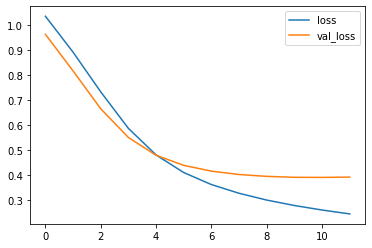

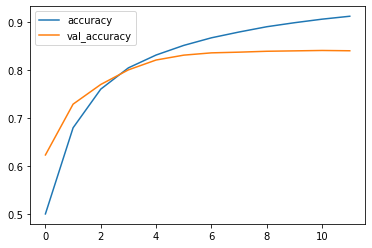

In [38]:
history = nnlm_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Training Swivel

In [39]:
swivel_model = build_model(swivel_module, name='swivel')

In [40]:
swivel_history = train_and_evaluate(data, val_data, swivel_model)

2021-10-25 20:33:55.754425: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-25 20:33:55.754484: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-25 20:33:55.754582: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
 2/19 [==>...........................] - ETA: 5s - loss: 1.2487 - accuracy: 0.3146

2021-10-25 20:33:58.641314: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-25 20:33:58.641376: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-25 20:33:59.019669: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-25 20:33:59.021148: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-25 20:34:01.263971: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/train/plugins/profile/2021_10_25_20_33_59

2021-10-25 20:34:01.578489: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/train/plugins/profile/2021_10_25_20_33_59/asl.trace.json.gz
2021-10-25 20:34:01.764776: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating d

12/19 [=================>............] - ETA: 3s - loss: 1.2058 - accuracy: 0.3317

2021-10-25 20:34:03.692990: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/train/plugins/profile/2021_10_25_20_33_59
Dumped tool data for xplane.pb to gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/train/plugins/profile/2021_10_25_20_33_59/asl.xplane.pb
Dumped tool data for overview_page.pb to gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/train/plugins/profile/2021_10_25_20_33_59/asl.overview_page.pb
Dumped tool data for input_pipeline.pb to gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/train/plugins/profile/2021_10_25_20_33_59/asl.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/train/plugins/profile/2021_10_25_20_33_59/asl.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/train/plugins/profile/2021_10_25_20_33_59/asl.kernel_stats.pb



19/19 [==============================] - 8s 414ms/step - loss: 1.1818 - accuracy: 0.3467 - val_loss: 1.1075 - val_accuracy: 0.4035
Epoch 2/100
19/19 [==============================] - 1s 36ms/step - loss: 1.0601 - accuracy: 0.4482 - val_loss: 1.0174 - val_accuracy: 0.4899
Epoch 3/100
19/19 [==============================] - 1s 37ms/step - loss: 0.9858 - accuracy: 0.5231 - val_loss: 0.9545 - val_accuracy: 0.5469
Epoch 4/100
19/19 [==============================] - 1s 37ms/step - loss: 0.9284 - accuracy: 0.5718 - val_loss: 0.9008 - val_accuracy: 0.5841
Epoch 5/100
19/19 [==============================] - 1s 39ms/step - loss: 0.8762 - accuracy: 0.6090 - val_loss: 0.8493 - val_accuracy: 0.6225
Epoch 6/100
10/19 [==============>...............] - ETA: 0s - loss: 0.8312 - accuracy: 0.6385

2021-10-25 20:34:15.246395: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/validation/events.out.tfevents.1635194044.asl.7811.3.v2


19/19 [==============================] - 1s 36ms/step - loss: 0.8241 - accuracy: 0.6412 - val_loss: 0.7992 - val_accuracy: 0.6512
Epoch 7/100
19/19 [==============================] - 1s 37ms/step - loss: 0.7720 - accuracy: 0.6683 - val_loss: 0.7508 - val_accuracy: 0.6784
Epoch 8/100
19/19 [==============================] - 1s 36ms/step - loss: 0.7217 - accuracy: 0.6932 - val_loss: 0.7062 - val_accuracy: 0.7003
Epoch 9/100
19/19 [==============================] - 1s 37ms/step - loss: 0.6761 - accuracy: 0.7135 - val_loss: 0.6677 - val_accuracy: 0.7194
Epoch 10/100
19/19 [==============================] - 1s 39ms/step - loss: 0.6364 - accuracy: 0.7312 - val_loss: 0.6358 - val_accuracy: 0.7350
Epoch 11/100
19/19 [==============================] - 1s 37ms/step - loss: 0.6032 - accuracy: 0.7451 - val_loss: 0.6097 - val_accuracy: 0.7462
Epoch 12/100
19/19 [==============================] - 1s 37ms/step - loss: 0.5754 - accuracy: 0.7575 - val_loss: 0.5879 - val_accuracy: 0.7570
Epoch 13/100
19

2021-10-25 20:34:37.385066: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/validation/events.out.tfevents.1635194044.asl.7811.3.v2


19/19 [==============================] - 5s 302ms/step - loss: 0.4488 - accuracy: 0.8146 - val_loss: 0.5006 - val_accuracy: 0.7955
Epoch 21/100
19/19 [==============================] - 1s 37ms/step - loss: 0.4392 - accuracy: 0.8194 - val_loss: 0.4954 - val_accuracy: 0.7980
Epoch 22/100
19/19 [==============================] - 1s 37ms/step - loss: 0.4303 - accuracy: 0.8233 - val_loss: 0.4910 - val_accuracy: 0.7984
Epoch 23/100
19/19 [==============================] - 1s 38ms/step - loss: 0.4222 - accuracy: 0.8274 - val_loss: 0.4878 - val_accuracy: 0.8013
Epoch 24/100
19/19 [==============================] - 1s 38ms/step - loss: 0.4147 - accuracy: 0.8307 - val_loss: 0.4847 - val_accuracy: 0.8038
Epoch 25/100
19/19 [==============================] - 2s 101ms/step - loss: 0.4077 - accuracy: 0.8343 - val_loss: 0.4824 - val_accuracy: 0.8046


2021-10-25 20:34:47.466469: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/validation/events.out.tfevents.1635194044.asl.7811.3.v2


Epoch 26/100
19/19 [==============================] - 1s 37ms/step - loss: 0.4012 - accuracy: 0.8375 - val_loss: 0.4804 - val_accuracy: 0.8030
Epoch 27/100
19/19 [==============================] - 1s 37ms/step - loss: 0.3953 - accuracy: 0.8403 - val_loss: 0.4788 - val_accuracy: 0.8050
Epoch 28/100
19/19 [==============================] - 1s 35ms/step - loss: 0.3897 - accuracy: 0.8432 - val_loss: 0.4777 - val_accuracy: 0.8052
Epoch 29/100
19/19 [==============================] - 1s 36ms/step - loss: 0.3845 - accuracy: 0.8454 - val_loss: 0.4768 - val_accuracy: 0.8042
Epoch 30/100
19/19 [==============================] - 4s 198ms/step - loss: 0.3797 - accuracy: 0.8473 - val_loss: 0.4758 - val_accuracy: 0.8054


2021-10-25 20:34:57.149089: I tensorflow/core/platform/cloud/gcs_file_system.cc:580] ### RequestUploadSessionStatus: completed = 1, already_uploaded = 0, file = gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models/swivel/validation/events.out.tfevents.1635194044.asl.7811.3.v2


Epoch 31/100
19/19 [==============================] - 1s 39ms/step - loss: 0.3752 - accuracy: 0.8492 - val_loss: 0.4757 - val_accuracy: 0.8038
Epoch 32/100
19/19 [==============================] - 1s 38ms/step - loss: 0.3710 - accuracy: 0.8512 - val_loss: 0.4751 - val_accuracy: 0.8059
Epoch 33/100
19/19 [==============================] - 1s 37ms/step - loss: 0.3670 - accuracy: 0.8533 - val_loss: 0.4746 - val_accuracy: 0.8048
Epoch 34/100
19/19 [==============================] - 1s 39ms/step - loss: 0.3632 - accuracy: 0.8549 - val_loss: 0.4750 - val_accuracy: 0.8038


<AxesSubplot:>

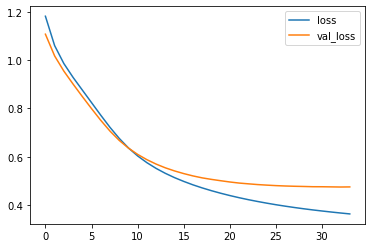

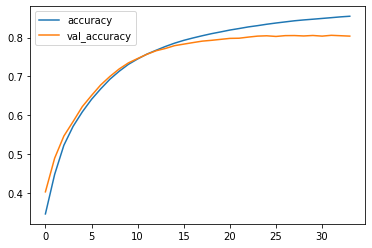

In [41]:
history = swivel_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

## Comparing the models

Swivel trains faster but achieves a lower validation accuracy, and requires more epochs to train on.

At last, let's compare all the models we have trained at once using TensorBoard in order
to choose the one that overfits the less for the same performance level.

Run the output of the following command in your Cloud Shell to launch TensorBoard, and use the Web Preview on port 6006 to view it.

In [42]:
!echo tensorboard --logdir $MODEL_DIR --port 6006

tensorboard --logdir gs://qwiklabs-gcp-00-eeb852ce8ccb/text_models --port 6006


## Deploying the model

The first step is to serialize one of our trained Keras model as a SavedModel:

In [43]:
OUTPUT_DIR = "./savedmodels_vertex"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

EXPORT_PATH = os.path.join(OUTPUT_DIR, 'swivel')
os.environ['EXPORT_PATH'] = EXPORT_PATH

shutil.rmtree(EXPORT_PATH, ignore_errors=True)

tf.keras.models.save_model(swivel_model, EXPORT_PATH)

2021-10-25 20:35:04.215669: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./savedmodels_vertex/swivel/assets


INFO:tensorflow:Assets written to: ./savedmodels_vertex/swivel/assets


Then we can deploy the model using the gcloud CLI as before:

In [44]:
%%bash

# TODO 5

TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
MODEL_DISPLAYNAME=title_model_$TIMESTAMP
ENDPOINT_DISPLAYNAME=swivel_$TIMESTAMP
IMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest"
ARTIFACT_DIRECTORY=gs://${BUCKET}/${MODEL_DISPLAYNAME}/
echo $ARTIFACT_DIRECTORY

gsutil cp -r ${EXPORT_PATH}/* ${ARTIFACT_DIRECTORY}

# Model
MODEL_RESOURCENAME=$(gcloud ai models upload \
    --region=$REGION \
    --display-name=$MODEL_DISPLAYNAME \
    --container-image-uri=$IMAGE_URI \
    --artifact-uri=$ARTIFACT_DIRECTORY \
    --format="value(model)")

echo "MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}"
echo "MODEL_RESOURCENAME=${MODEL_RESOURCENAME}"

# Endpoint
ENDPOINT_RESOURCENAME=$(gcloud ai endpoints create \
  --region=$REGION \
  --display-name=$ENDPOINT_DISPLAYNAME \
  --format="value(name)")

echo "ENDPOINT_DISPLAYNAME=${ENDPOINT_DISPLAYNAME}"
echo "ENDPOINT_RESOURCENAME=${ENDPOINT_RESOURCENAME}"

# Deployment
DEPLOYED_MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}_deployment
MACHINE_TYPE=n1-standard-2
MIN_REPLICA_COUNT=1
MAX_REPLICA_COUNT=3

gcloud ai endpoints deploy-model $ENDPOINT_RESOURCENAME \
  --region=$REGION \
  --model=$MODEL_RESOURCENAME \
  --display-name=$DEPLOYED_MODEL_DISPLAYNAME \
  --machine-type=$MACHINE_TYPE \
  --min-replica-count=$MIN_REPLICA_COUNT \
  --max-replica-count=$MAX_REPLICA_COUNT \
  --traffic-split=0=100

gs://qwiklabs-gcp-00-eeb852ce8ccb/title_model_20211025_203504/
MODEL_DISPLAYNAME=title_model_20211025_203504
MODEL_RESOURCENAME=projects/432069008306/locations/us-central1/models/7657249664483196928
ENDPOINT_DISPLAYNAME=swivel_20211025_203504
ENDPOINT_RESOURCENAME=projects/432069008306/locations/us-central1/endpoints/3510001755674902528


Copying file://./savedmodels_vertex/swivel/assets/tokens.txt [Content-Type=text/plain]...
Copying file://./savedmodels_vertex/swivel/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://./savedmodels_vertex/swivel/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./savedmodels_vertex/swivel/variables/variables.index [Content-Type=application/octet-stream]...
- [4 files][264.1 KiB/264.1 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://./savedmodels_vertex/swivel/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
\ [5 files][  4.7 MiB/  4.7 MiB]                                                
Operation completed over 5 objects/4.7 MiB.          

Note the `ENDPOINT_RESOURCENAME` above as you'll need it below for the prediction.

Before we try our deployed model, let's inspect its signature to know what to send to the deployed API:

In [45]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_1_input'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_keras_layer_1_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall_2:0
Method name is: tensorflow/serving/predict
./savedmodels_vertex/swivel
./savedmodels_vertex/swivel/keras_metadata.pb
./savedmodels_vertex/swivel/assets
./savedmodels_vertex/swivel/assets/tokens.txt
./savedmodels_vertex/swivel/saved_model.pb
./savedmodels_vertex/swivel/variables
./savedmodels_vertex/swivel/variables/variables.index
./savedmodels_vertex/swivel/variables/variables.data-00000-of-00001


Let's go ahead and hit our model:

In [50]:
%%writefile input.json
{
    "instances": [
        {"keras_layer_1_input": "Inside the Thai Temple Where Tattoos Come to Life"}
    ]
}

Overwriting input.json


Insert below the `ENDPOINT_RESOURCENAME` from the deployment code above.

In [51]:
%%bash
ENDPOINT_RESOURCENAME="projects/432069008306/locations/us-central1/endpoints/3510001755674902528"
gcloud ai endpoints predict $ENDPOINT_RESOURCENAME \
  --region $REGION \
  --json-request input.json

[[0.98960191, 0.00973256119, 0.000665530621]]


Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]


## Bonus

Try to beat the best model by modifying the model architecture, changing the TF-Hub embedding, and tweaking the training parameters.

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License